# Denoising MNIST with U-Net

In this script, we are denoising mnist samples using segmentation. This is just a small usecase of the unet used later in DDPMs. 

Using original structure (segmentation):

The idea is to segment "written" (white) from "background" (black) data, while training on different noise scales and obtaining the ground truth by thresholding.
* class 0 (background): pixelvalue < 0.5
* class 1 (written digit): pixelvalue >= 0.5

Using modified structure (image output):
* remove n_classes from Unet and output n_channels --> only image prediction
* this model is used for DDPMs too


Both ways converge to similar solution, however the first one looks cleaner since the model outputs a classification of pixels if threshold is applied.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

transform = torchvision.transforms.transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST('./../data', train=True, transform=transform, download=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = torchvision.datasets.MNIST('./../data', train=False, transform=transform, download=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

Device: cuda:0


In [4]:
# from simple_unet import SimpleSegmentationUNet, SimpleUNet
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch

# Modified from https://github.com/obravo7/satellite-segmentation-pytorch/blob/master/models/unet.py to small and for generation instead of segmentation

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvLayer, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_layer(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True
            )
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=1
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.first_layer = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

        self.out = OutConv(64, self.n_classes)

    def forward(self, x):
        x1 = self.first_layer(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        out = self.out(x)
        return out
    
class SmallUNet(nn.Module):
    def __init__(self, n_channels, bilinear=True):
        super(SmallUNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.first_layer = DoubleConv(n_channels, 8)
        self.down1 = Down(8, 16) # maxpool -> doubleconv
        self.down2 = Down(16, 32) # maxpool -> doubleconv

        factor = 2 if bilinear else 1
        self.down3 = Down(32, 64 // factor)
        
        self.up1 = Up(64, 32 // factor, bilinear) # upsample -> doubleconv
        self.up2 = Up(32, 16 // factor, bilinear)  # upsample -> doubleconv
        self.up3 = Up(16,8, bilinear)

        self.out = OutConv(8, self.n_channels)

    def forward(self, x):

        x1 = self.first_layer(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)

        out = self.out(x)
        return out

model = SmallUNet(n_channels=1)
model.to(device)

SmallUNet(
  (first_layer): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=1e-05, mome

### Training Loop

In [6]:
# from simple_unet import SimpleSegmentationUNet, SimpleUNet
import matplotlib.pyplot as plt
import numpy as np

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
mse = torch.nn.MSELoss()
threshold = 0.5

T = 1000
beta_schedule = np.linspace(start=1e-4, stop=0.02, num=T)
alpha_cumprod = np.cumprod(1 - beta_schedule) 

def preprocess(batch):

    # Noise creation equivalent to DDPMs
    t = np.random.randint(int(T*0),T, size=(batch.shape[0]))
    noise = np.random.normal(size=batch.shape)
    alpha = alpha_cumprod[t]
    xt = batch.cpu().detach().numpy().copy()
    for j in range(xt.shape[0]):
        xt[j] = np.sqrt(alpha[j]) * batch[j] + (1-alpha[j]) * noise[j] # in terms of x0
    xt = torch.tensor(xt)

    return xt

def train_one_epoch(epoch_number, iterations_per_epoch=500):

    running_loss = 0.
    last_loss = 0.

    for i, (batch, labels) in enumerate(train_dataloader):

        if i >= iterations_per_epoch:
            break

        ground_truth = torch.round(batch)
        ground_truth = ground_truth.to(device)

        xt = preprocess(batch)
        xt = xt.to(device)
        
        optimizer.zero_grad()

        prediction = model(xt)

        loss = mse(prediction,ground_truth)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if i % iterations_per_epoch == iterations_per_epoch-1:

            # training loss
            last_loss = running_loss / iterations_per_epoch # loss per batch
            # print('Iteration {} loss: {}'.format(epoch_number*iterations_per_epoch + i+1, last_loss))
            print('Iteration {}'.format(epoch_number*iterations_per_epoch + i+1))
            running_loss = 0.

            # training results so far
            concat = torch.concat((xt, ground_truth, prediction), dim=1)
            imgs = torchvision.utils.make_grid(concat).detach().cpu().numpy()
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes = axes.flatten()
            for k, (img, title) in enumerate(zip(imgs,['noisy input', 'ground truth', 'prediction handwritten'])):
                axes[k].imshow(img)
                axes[k].set_title(title)
                axes[k].axis('off')
            plt.show()

    return last_loss


EPOCH 1:
Iteration 200


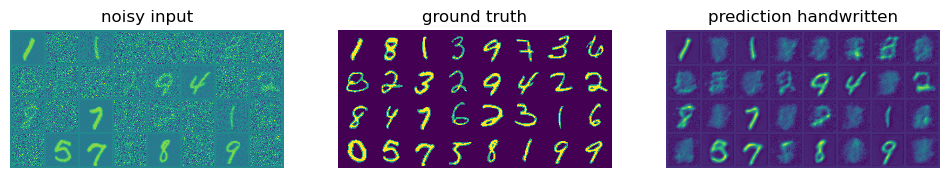

LOSS train 0.45881240159273146 valid 0.3487951159477234
EPOCH 2:
Iteration 400


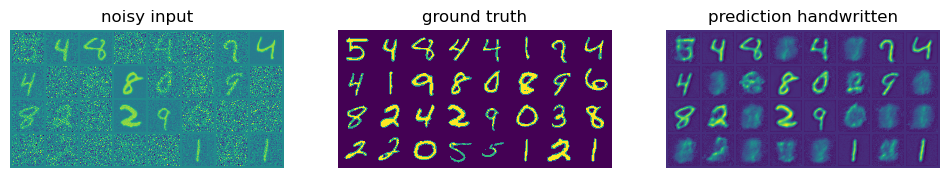

LOSS train 0.31893115684390066 valid 0.30245456099510193
EPOCH 3:
Iteration 600


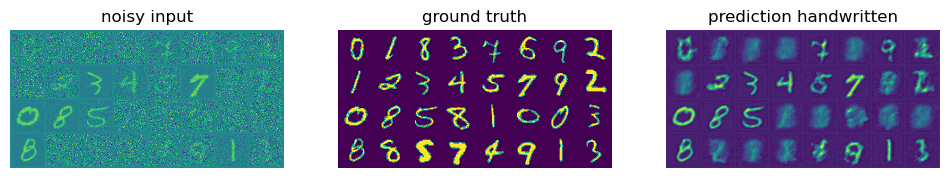

LOSS train 0.29474190942943096 valid 0.2880551218986511
EPOCH 4:
Iteration 800


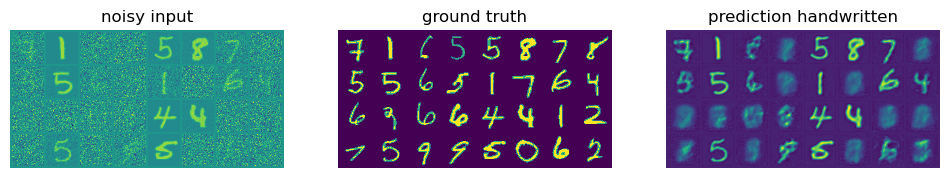

LOSS train 0.28262698255479335 valid 0.2740907371044159
EPOCH 5:
Iteration 1000


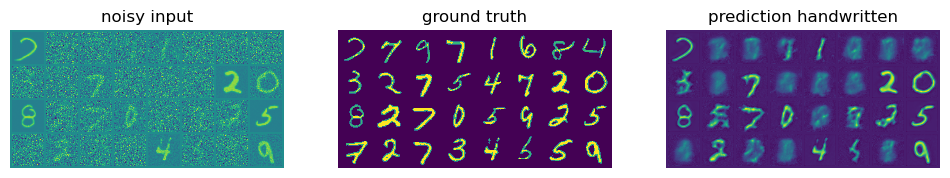

LOSS train 0.27913917787373066 valid 0.2736094892024994
EPOCH 6:
Iteration 1200


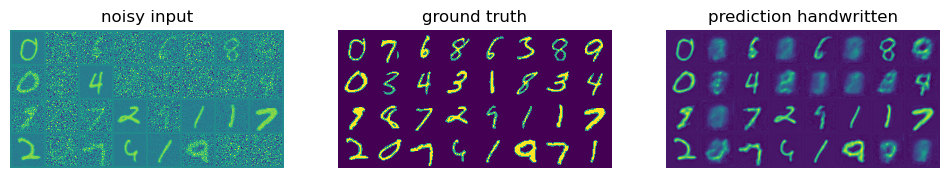

LOSS train 0.2703643276542425 valid 0.2713439166545868
EPOCH 7:
Iteration 1400


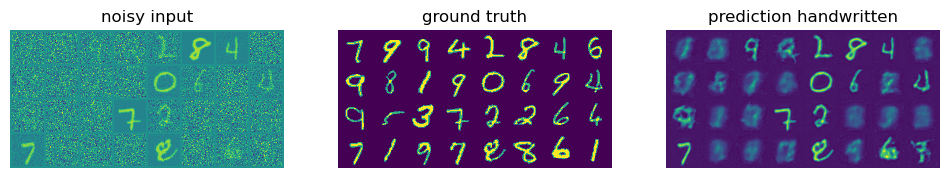

LOSS train 0.27290490113198757 valid 0.2648163437843323
EPOCH 8:
Iteration 1600


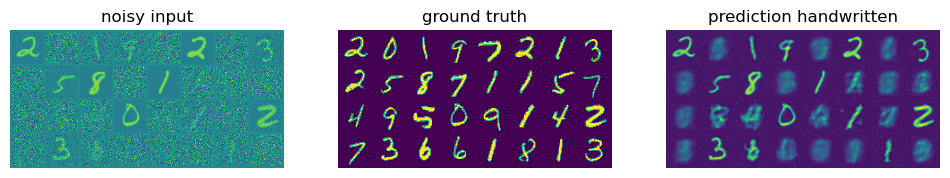

LOSS train 0.2678715743869543 valid 0.26562976837158203
EPOCH 9:
Iteration 1800


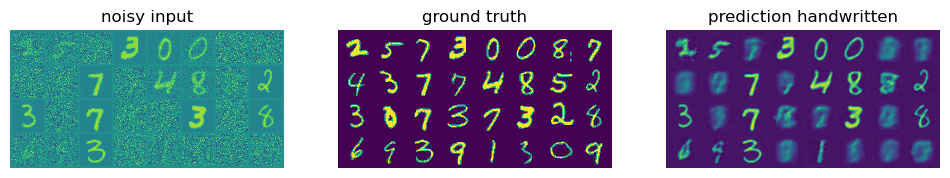

LOSS train 0.2671065451949835 valid 0.2617553770542145
EPOCH 10:
Iteration 2000


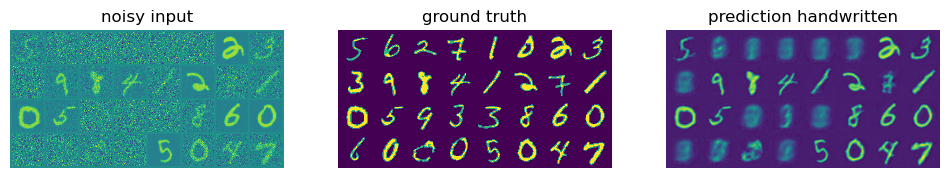

LOSS train 0.2624491673707962 valid 0.2591072618961334
EPOCH 11:
Iteration 2200


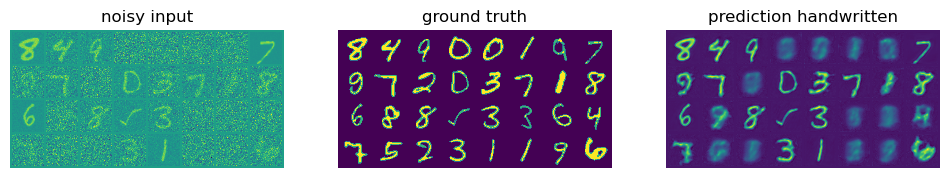

LOSS train 0.2613801734894514 valid 0.25990617275238037
EPOCH 12:
Iteration 2400


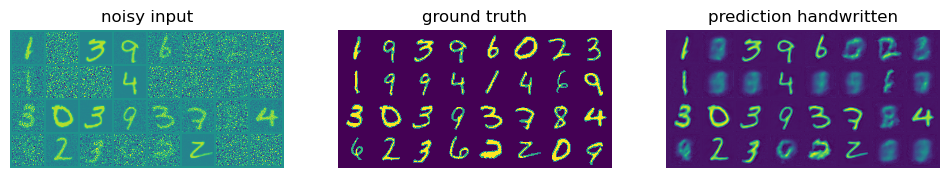

LOSS train 0.2591263368725777 valid 0.25976574420928955
Validation loss did not increase for 2 epochs, keeping checkpoint of epoch 10


In [7]:
import datetime 

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
EPOCHS = 20
best_vloss = 10000

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    avg_loss = train_one_epoch(epoch_number, iterations_per_epoch=200)

    running_vloss = 0.0

    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):
            batch, vlabels = vdata
            
            ground_truth = torch.round(batch)
            ground_truth = ground_truth.to(device)

            xt = preprocess(batch)
            xt = xt.to(device)

            prediction = model(xt)
            vloss = mse(prediction, ground_truth)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    if avg_vloss < best_vloss:
        vloss_count = 0
        best_vloss = avg_vloss
        model_path = 'denoising_unet.ckpt' # just saving best
        torch.save(model.state_dict(), model_path)
    else:
        vloss_count += 1
        if vloss_count == 2:
            print(f'Validation loss did not increase for 2 epochs, keeping checkpoint of epoch {epoch_number-2+1}')
            break

    epoch_number += 1